In [4]:
from utils.paths import *
from utils.raster_utils import *

import plotly.express as px

In [5]:
gps_coords = 46.03859, 7.66788
grid_size = 10
radius = 2000
path = '/Users/george-birchenough/sunmap_rasters/Switzerland_DEM_10m.tif'

array, observer_pixel, observer_height = get_square_masked_data(gps_coords, radius, grid_size, path)
array_cartesian = np.flip(array, axis=0)
elevation = 10
azimuth = 260

In [6]:

inter_grid_size = 5
nrows,ncols = array.shape
x_points = np.arange(ncols)
y_points = np.arange(nrows)
xy_points = (np.arange(nrows), np.arange(ncols))
# xy_points = ( np.arange(ncols), np.arange(nrows))

array_cartesian = np.flip(array, axis=0)
x_vector, y_vector, quadrant = get_azimuth_vector(azimuth)
x_vector*=inter_grid_size
y_vector*=inter_grid_size

df = pd.DataFrame()
fig = go.Figure()

y_starts =  np.arange(0, nrows, inter_grid_size**2 / abs(x_vector))
for y_start in y_starts:
    # print('row ',y_start, ' of ', nrows)
    # We make interpolation points starting from first column of each row.
    x_start = 0 if x_vector > 0 else ncols
    x_sample = x_start
    y_sample = y_start
    inter_points = [[y_sample, x_sample]]

    while y_sample >= 0 and y_sample <= nrows  and x_sample >= 0 and x_sample <= ncols :

        y_sample = y_sample + y_vector
        x_sample = x_sample + x_vector
        inter_points_ = [[y_sample, x_sample]]
        inter_points = np.concatenate([ inter_points , inter_points_ ])

    heights = interpn(xy_points, array_cartesian, inter_points, \
                method = 'linear', bounds_error = False, fill_value = 0 ) 
    distances =  np.arange(len(inter_points)) * inter_grid_size  # in metres
    df = pd.concat([df, get_shadows(heights, distances, inter_points, elevation)])

    # fig.add_trace( dict(
    #             type = 'scatter',
    #             x = [inter_point[1] for inter_point in inter_points],
    #             y = [inter_point[0] for inter_point in inter_points],
    #             mode = 'lines'
    #             )
    #     )

x_starts = np.arange(0, ncols, inter_grid_size**2 / abs(y_vector))
for x_start in x_starts:
    # print('row ',y_start, ' of ', nrows)
    # We make interpolation points starting from first column of each row.
    y_start = 0 if y_vector > 0 else nrows
    x_sample = x_start
    y_sample = y_start
    inter_points = [[y_sample, x_sample]]

    while y_sample >= 0 and y_sample <= nrows and x_sample >= 0 and x_sample <= ncols :
        y_sample = y_sample + y_vector
        x_sample = x_sample + x_vector
        inter_points_ = [[y_sample, x_sample]]
        inter_points = np.concatenate([ inter_points , inter_points_ ])

    heights = interpn(xy_points, array_cartesian, inter_points, \
                method = 'linear', bounds_error = False, fill_value = 0 ) 
    distances =  np.arange(len(inter_points)) * inter_grid_size  # in metres
    df = pd.concat([df, get_shadows(heights, distances, inter_points, elevation)])

z=array_cartesian
x=x_points * grid_size
y=y_points * grid_size

fig.add_trace( dict(
        type = 'contour',
        z=z,
        x=x,
        y=y,
        contours = dict(
            start = z.min().round(100),
            end = z.max().round(100),
            size = 50,
            coloring = 'none',
            showlabels = True,
        ),
        showlegend = False,
    ))

fig.add_trace( dict(
        type = 'contour',
        z=z,
        x=x,
        y=y,
        contours = dict(
            start = z.min().round(10),
            end = z.max().round(10),
            size = 10,
            # coloring = 'none',
            ),
        opacity = 0.5,
        showlegend = False,
    ))
    
df.fillna(0,inplace=True)
df = df.loc[df.shadow == 1]

fig.add_trace( dict(
            type = 'scatter',
            x = df.x * grid_size,
            y = df.y * grid_size,
            mode = 'markers',
            marker = {'color':'black', 'size':5},
            opacity = 0.5
            )
    )

fig.update_layout(
    autosize = False,
    height = 800,
    width = 800,
    yaxis = dict(
            scaleanchor = 'x',
            scaleratio = 1
        ),
    xaxis = dict(
        range = [0, 2 * radius]
        )
    )

fig.show()


/Users/george-birchenough/opt/anaconda3/envs/solmap/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning:

overflow encountered in multiply

/Users/george-birchenough/opt/anaconda3/envs/solmap/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning:

overflow encountered in multiply



In [16]:
fig2 = go.Figure()


fig2.add_trace( dict(
            type = 'contour',
            x = df.x * grid_size,
            y = df.y * grid_size,
            z = df.shadow,
            # mode = 'markers',
            # marker = {'color':'black', 'size':5},
            opacity = 0.5
            )
    )

fig2.update_layout(
    autosize = False,
    height = 800,
    width = 800,
    yaxis = dict(
            scaleanchor = 'x',
            scaleratio = 1
        ),
    xaxis = dict(
        range = [0, 2 * radius]
        )
    )

fig2.show()


In [18]:
df

d            z           x           y      max_el  shadow
0     0     0.000000  401.000000    5.077133  586.404960     1.0
1     5  2932.024800  396.075961    4.208892    0.943108     1.0
2    10  2909.246542  391.151922    3.340651    3.838918     1.0
3    15  2928.441134  386.227884    2.472410    2.839138     1.0
4    20  2942.636825  381.303845    1.604170    1.650025     1.0
..  ...          ...         ...         ...         ...     ...
67  335  2836.430236   44.409484  342.827860    5.609739     1.0
68  340  2827.127323   39.485445  341.959620    8.099846     1.0
69  345  2857.267258   34.561407  341.091379    9.135775     1.0
70  350  2898.562541   29.637368  340.223138   10.012493     1.0
75  375  2743.367673    5.017174  335.881933    0.339177     1.0

[4636 rows x 6 columns]

In [7]:
# # x_s = df.x * 1000 / n_steps
# # y_s = (df.y * 1000 / n_steps)[::-1]
# # z_s = df.shadow

# z = array
# x = np.arange(0, 2*radius+grid_size, grid_size)
# y = x[::-1]

# slope_array = np.gradient(z)
# slope = ( ( np.array( slope_array[0]) **2 + np.array( slope_array[1]) **2 ) ** 0.5 ) / grid_size
# slope = np.arctan(slope) * 180 / np.pi

# fig = go.Figure()

# fig.add_trace( dict(
#         type = 'contour',
#         z=z,
#         x=x,
#         y=y,
#         contours = dict(
#             start = z.min().round(100),
#             end = z.max().round(100),
#             size = 50,
#             coloring = 'none',
#             showlabels = True,
#         ),
#         showlegend = False,
#     ))

# fig.add_trace( dict(
#         type = 'contour',
#         z=z,
#         x=x,
#         y=y,
#         contours = dict(
#             start = z.min().round(10),
#             end = z.max().round(10),
#             size = 10,
#             coloring = 'none',
#             ),
#         showlegend = False,
#     ))
    
# fig.update_layout(
#     autosize = False,
#     height = 800,
#     width = 800,
#     yaxis = dict(
#             scaleanchor = 'x',
#             scaleratio = 1
#     ),
#     xaxis = dict(
#         range = [0, 2*radius]
#     )
# )

# # fig.add_trace( dict(
# #         type = 'heatmap',
# #         z = z_s,
# #         x= x_s,
# #         y= y_s,
# #         opacity = 0.5
# #         # contours = dict(
# #         #     start = array.min().round(10),
# #         #     end = array.max().round(10),
# #         #     size = 10,
# #         #     coloring = 'none',
# #         #     )
# #     ))

# def make_colormap(slope):
#     range = slope.max() - slope.min()

#     discrete_angles = np.array( [slope.min(), 30, 35, 40, 45, 50, 55, slope.max()] )

#     norm_intervals = ( discrete_angles - slope.min() ) / range

#     map = [(slope.min(),'white'), (30,'white'), (35,'#F0E54D'), (40,'#E4773B'), (45, '#CC2D5C'), (50, '#BF8CB8'), (55, '#524691'), (60, '#8BC4BF'),  (90, '#1D1D1B')]

#     mapless = []
#     for i in np.arange(len(map)):
#         if map[i][0] < slope.max():
#             mapless.append([ map[i][0], map[i][1] ] )
#             largest_index = i

#     mapless.append( [slope.max(), map[largest_index][1]] )


#     dcolors = []
#     for i in np.arange(len(mapless)):
#         try:
#             dcolors.append( [ (mapless[i][0]-slope.min())/range  , mapless[i][1] ] )
#             dcolors.append( [ (mapless[i][0]-slope.min())/range  , mapless[i+1][1] ] )
#         # print( i[0],i[1] )
#         except:
#             pass
#     return dcolors

# # dcolors = make_colormap(slope)
# # fig.add_trace( dict(
# #         type = 'heatmap',
# #         z = slope,
# #         x=x,
# #         y=y,
# #         colorscale = dcolors,
# #         opacity = 0.5
# #         # contours = dict(
# #         #     start = array.min().round(10),
# #         #     end = array.max().round(10),
# #         #     size = 10,
# #         #     coloring = 'none',
# #         #     )
# #     ))

# fig.show()

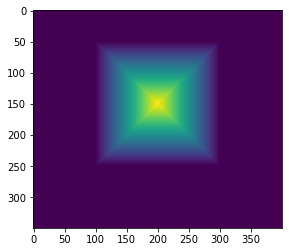

In [8]:
edge_length = int( 2 * radius / grid_size)
pyramid_length = int( edge_length / 2 )
array = np.zeros([pyramid_length,pyramid_length])
inset = int((edge_length - pyramid_length)/2)
for i in np.arange(pyramid_length):
    # i+=inset
    array[ i:pyramid_length-i,i:pyramid_length-i ] = i

array = np.pad(array, [(inset, int( inset / 2) ), (inset, inset)], mode='constant', constant_values=0)
array = np.flip(array, axis=0)
plt.imshow(array)